<div style="display: flex; background-color: Blue; padding: 15px;" >

## 0.Créations des descripteurs de chaque image 
</div>

1. Pour chaque image passage en gris et equalisation

2. création d'une liste de descripteurs par image ("sift_keyspoints_img") qui sera utilisée pour réaliser les histogrammes par image

3. création d'une liste de descripteurs pour l'ensemble des images ("sift_keyspoints_all_imag") qui sera utilisé pour créer les clusters de descripteurs (on vera çe on détaille  aprés)

In [38]:
from os import getcwd
import pandas as pd
import numpy as np 
import sys
sys.path.append("C:\\Users\\User\\WORK\\workspace-ia\\PERSO\\")
from ara_commons import ara_picture_function as ara_pict
from ara_commons.ara_file import get_dir_files
import matplotlib.pyplot as plt

In [39]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
force_reloading = True

# Récupère le répertoire du programme
file_path = getcwd() + "\\"
file_path

'c:\\Users\\User\\WORK\\workspace-ia\\simplon\\2022-03-Images\\'

In [40]:
source_data_path = file_path+"dataset\\"
print("Source path :", source_data_path)

Source path : c:\Users\User\WORK\workspace-ia\simplon\2022-03-Images\dataset\


In [41]:
# récupération données
img_extensions = [".jpg", ".jpeg", ".png"]
images = []

for ext in img_extensions:
    images.extend(get_dir_files(source_data_path, endwith=ext))

print(len(images), "images")

400 images


In [42]:
from collections import defaultdict
import re

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 1.Extract keypoints from each image
</div>

In [111]:
nb_descriptors=500

In [112]:
img_dic = defaultdict(list)
img_descriptors_dic = defaultdict(list)
sift_keyspoints_img=[]
sift_keyspoints_all_img = []

pattern = ara_pict.get_regex_alphabetique_simple()

for img_path in images:
    try:
        img_dic["file_name"].append(img_path)
        name = img_path.lower().split(".")[0]
        name = re.sub(pattern, '', name).strip()
        img_dic["y"].append(name)
        grayimage, keypoint, descriptor = ara_pict.define_img_point(source_data_path+img_path, nb_descriptors=nb_descriptors, display=False, verbose=verbose)
        sift_keyspoints_img.append(descriptor)
        img_descriptors_dic[img_path] = descriptor
        sift_keyspoints_all_img.extend(descriptor)
    except Exception as error:
        print("ERROR : ", img_path)
        print(error)
    

In [113]:
print(len(sift_keyspoints_all_img), len(sift_keyspoints_all_img[0]))

150144 128


In [114]:
df_origin = pd.DataFrame.from_dict(img_dic)
print(df_origin.shape)
df_origin.columns

(400, 2)


Index(['file_name', 'y'], dtype='object')

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 2.Clustering
</div>

We now have an array with a huge number of descriptors. We cannot use all of them to create or model so we need to cluster them. A rule-of-thumb is to create k centers with k = number of categories * 10 (in our case, it's 990).

In [47]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier

In [48]:
species = df_origin["y"].sort_values().unique()
species

array(['cloudy', 'rain', 'shine', 'sunrise'], dtype=object)

In [115]:
# ou sqrt(len(nbrs_descripteurs))

n_clusters=df_origin["y"].sort_values().nunique() * 100
n_clusters = round(np.sqrt(len(sift_keyspoints_all_img)))
n_clusters

387

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 3.Création des clusters de descripteurs
</div>

* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [116]:
len(sift_keyspoints_all_img)

150144

In [117]:
batch_size = len(images) * 3
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, verbose=verbose).fit(sift_keyspoints_all_img)

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 4.Creation of the histograms
</div>

To create our each image by a histogram. We will create a vector of k value for each image. For each keypoints in an image, we will find the nearest center and increase by one its value.


In [52]:
def predict(n_clusters, kmeans, descriptor, model_MLPClassifier=None, verbose=0):
    nkp = len(descriptor)
    histo = np.zeros(n_clusters)

    for d in descriptor:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly
    
    probas = None
    if model_MLPClassifier is not None:
        probas = model_MLPClassifier.predict_proba([histo])

    return probas, histo

In [118]:
histo_list = []

for img_path in images:
    try:
        _, histo = predict(n_clusters, kmeans, descriptor=img_descriptors_dic[img_path], verbose=verbose)
        histo_list.append(histo)
    except Exception as error:
        print("ERROR : ", img_path)
        print(error)

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 5.Training of the neural network
</div>

In [55]:
type(species)

numpy.ndarray

In [119]:
X = np.array(histo_list)
Y = []

# It's a way to convert species name into an integer
for s in df_origin["y"].to_list():
    
    Y.append(np.min(np.nonzero(species == s)))

mlp = MLPClassifier(verbose=verbose, max_iter=600000)
mlp.fit(X, Y)
mlp.score(X, Y)

1.0

In [124]:
df_origin["y"]

0       cloudy
1       cloudy
2       cloudy
3       cloudy
4       cloudy
        ...   
395    sunrise
396    sunrise
397    sunrise
398    sunrise
399    sunrise
Name: y, Length: 400, dtype: object

In [108]:
from sklearn import svm

In [120]:
sv = svm.SVC()
sv.fit(X, Y)
sv.score(X, Y)

0.89

In [110]:
# sv.score(X_test, Y_test)

0.46774193548387094

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 6.Prédictions
</div>

In [58]:
import csv

In [59]:
def pred_df(source_data_path, image_list, n_clusters, kmeans, mlp, species,img_descriptors_dic, file_name=None, verbose=0):
    df_test_dict =  defaultdict(list)
    if file_name is not None:
        result_file = open(source_data_path+ file_name, "w")
        result_file_obj = csv.writer(result_file)
        result_file_obj.writerow(np.append("id", species))

    histo_list = []
    
    for img_path in image_list:
        try:
            probas, histo = predict(n_clusters, kmeans, descriptor=img_descriptors_dic[img_path], model_MLPClassifier=mlp, verbose=verbose)
            proba = probas[0]
            histo_list.append(histo)

            if file_name is not None:
                row = []
                row.append(img_path)
                for e in probas[0]:
                    row.append(e)

                result_file_obj.writerow(row)

            name = img_path.lower().split(".")[0]
            name = re.sub(pattern, '', name).strip()
            
            df_test_dict["picture"].append(img_path)
            df_test_dict["target"].append(name)

            max_item = max(proba)
            pre = species[np.where(proba == max_item)][0]
            df_test_dict["predict"].append(pre)
            
            for i in range(0, len(proba)):
                df_test_dict[species[i]+"_proba_"+str(i)].append(round(proba[i],2))  

        except Exception as error:
            print("ERROR : ", img_path)
            print(error)
    return df_test_dict, histo_list

In [121]:
df_src_dict, histo_list = pred_df(source_data_path, images, n_clusters, kmeans, mlp, species,img_descriptors_dic=img_descriptors_dic, file_name="predict_source.csv")

In [122]:
df_src = pd.DataFrame(df_src_dict)
df_src

,picture,target,predict,cloudy_proba_0,rain_proba_1,shine_proba_2,sunrise_proba_3
0,cloudy1.jpg,cloudy,cloudy,0.98,0.00,0.02,0.00
1,cloudy10.jpg,cloudy,cloudy,0.94,0.00,0.05,0.00
2,cloudy100.jpg,cloudy,cloudy,0.91,0.00,0.09,0.00
3,cloudy11.jpg,cloudy,cloudy,0.88,0.01,0.09,0.02
4,cloudy12.jpg,cloudy,cloudy,0.96,0.00,0.02,0.01
...,...,...,...,...,...,...,...
395,sunrise96.jpg,sunrise,sunrise,0.00,0.00,0.08,0.92
396,sunrise97.jpg,sunrise,sunrise,0.01,0.00,0.00,0.99
397,sunrise98.jpg,sunrise,sunrise,0.00,0.00,0.02,0.98
398,sunrise99.jpg,sunrise,sunrise,0.00,0.00,0.00,1.00


In [125]:
source_data_test_path = source_data_path.replace("dataset", "dataset_test")

# récupération données
images_test = []

for ext in img_extensions:
    images_test.extend(get_dir_files(source_data_test_path, endwith=ext))

print(len(images_test), "images")
images_test[::3]

62 images


['cloudy002.jpg',
 'cloudy005.jpg',
 'cloudy008.jpg',
 'cloudy011.jpg',
 'cloudy014.jpg',
 'rain003.jpg',
 'rain006.jpg',
 'rain009.jpg',
 'rain012.jpg',
 'rain015.jpg',
 'shine003.jpg',
 'shine006.jpg',
 'shine009.jpg',
 'shine012.jpg',
 'shine015.jpg',
 'sunrise003.jpg',
 'sunrise007.jpg',
 'sunrise010.jpg',
 'sunrise013.jpg',
 'sunrise016.jpg',
 'rain015.jpeg']

In [126]:
img_descriptors_test_dic = defaultdict(list)

pattern = ara_pict.get_regex_alphabetique_simple()

for img_path in images_test:
    try:
        grayimage, keypoint, descriptor = ara_pict.define_img_point(source_data_test_path+img_path, nb_descriptors=nb_descriptors, display=False, verbose=verbose)       
        img_descriptors_test_dic[img_path] = descriptor
    except Exception as error:
        print("ERROR : ", img_path)
        print(error)

In [127]:
df_test_dict, histo_test_list = pred_df(source_data_test_path, images_test, n_clusters, kmeans, mlp, species, img_descriptors_dic=img_descriptors_test_dic, file_name="predict_test.csv")
df_test = pd.DataFrame(df_test_dict)
df_test

,picture,target,predict,cloudy_proba_0,rain_proba_1,shine_proba_2,sunrise_proba_3
0,cloudy002.jpg,cloudy,cloudy,0.98,0.00,0.02,0.00
1,cloudy003.jpg,cloudy,shine,0.29,0.00,0.71,0.00
2,cloudy004.jpg,cloudy,cloudy,0.42,0.28,0.29,0.02
3,cloudy005.jpg,cloudy,cloudy,1.00,0.00,0.00,0.00
4,cloudy006.jpg,cloudy,cloudy,0.82,0.00,0.11,0.07
...,...,...,...,...,...,...,...
57,sunrise016.jpg,sunrise,shine,0.00,0.00,0.99,0.01
58,cloudy001.jpeg,cloudy,shine,0.00,0.00,1.00,0.00
59,rain002.jpeg,rain,rain,0.00,0.99,0.01,0.00
60,rain015.jpeg,rain,sunrise,0.00,0.01,0.00,0.99


In [128]:
X_test = np.array(histo_test_list)
Y_test = []

# It's a way to convert species name into an integer
for s in df_test["target"].to_list():
    Y_test.append(np.min(np.nonzero(species == s)))

In [105]:
X_test.shape

(62, 322)

In [106]:
X_test

array([[0.        , 0.00333333, 0.00333333, ..., 0.        , 0.        ,
        0.00333333],
       [0.        , 0.01333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00666667, 0.00333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02333333, 0.        , 0.00666667, ..., 0.00333333, 0.        ,
        0.00666667],
       [0.00996678, 0.        , 0.00664452, ..., 0.00332226, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02439024, 0.17073171,
        0.        ]])

In [129]:
round(mlp.score(X_test, Y_test), 2)

0.53

In [67]:
df_test[df_test["target"]!=df_test["predict"]]

,picture,target,predict,cloudy_proba_0,rain_proba_1,shine_proba_2,sunrise_proba_3
4,cloudy006.jpg,cloudy,sunrise,0.32,0.00,0.03,0.65
5,cloudy007.jpg,cloudy,shine,0.01,0.10,0.85,0.04
8,cloudy010.jpg,cloudy,shine,0.00,0.01,0.93,0.05
9,cloudy011.jpg,cloudy,sunrise,0.24,0.00,0.04,0.73
11,cloudy013.jpg,cloudy,rain,0.44,0.47,0.08,0.00
13,cloudy015.jpg,cloudy,shine,0.01,0.00,0.99,0.00
20,rain008.jpg,rain,sunrise,0.00,0.09,0.00,0.91
21,rain009.jpg,rain,sunrise,0.07,0.03,0.00,0.91
22,rain010.jpg,rain,sunrise,0.00,0.00,0.00,1.00
23,rain011.jpg,rain,sunrise,0.00,0.00,0.00,1.00


In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [69]:
df_test.columns

Index(['picture', 'target', 'predict', 'cloudy_proba_0', 'rain_proba_1',
       'shine_proba_2', 'sunrise_proba_3'],
      dtype='object')

In [70]:
cf_m = confusion_matrix(df_test['target'], df_test['predict'])
df_confusion = pd.DataFrame(cf_m)
df_confusion

,0,1,2,3
0,8,1,4,2
1,0,11,0,5
2,9,2,3,1
3,1,5,3,7


In [71]:
df_confusion["expected"] = ""
for i in range(0, 4):
    df_confusion.loc[i,"expected"] = species[i]
    df_confusion = df_confusion.rename(columns={i:species[i]})

df_confusion

,cloudy,rain,shine,sunrise,expected
0,8,1,4,2,cloudy
1,0,11,0,5,rain
2,9,2,3,1,shine
3,1,5,3,7,sunrise


In [72]:
df_confusion = df_confusion.set_index("expected")
df_confusion

,cloudy,rain,shine,sunrise
expected,,,,
cloudy,8,1,4,2
rain,0,11,0,5
shine,9,2,3,1
sunrise,1,5,3,7


<AxesSubplot:ylabel='expected'>

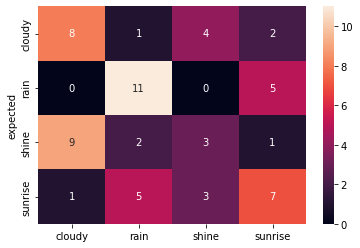

In [73]:
sns.heatmap(df_confusion, annot=True)

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 7.Représentation graphique
</div>

In [ ]:
X.shape

(400, 400)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
random_state = 0

In [ ]:
labels = [(species[i], i) for i in range(0,len(species))]
labels

[('cloudy', 0), ('rain', 1), ('shine', 2), ('sunrise', 3)]

In [93]:
colors = ['green','magenta', 'blue','orange','cyan', 'red','yellow','black']
colors_dic = {}
for i in range (0, len(species)):
    colors_dic[species[i]] = colors[i]
colors_dic

{'cloudy': 'green', 'rain': 'magenta', 'shine': 'blue', 'sunrise': 'orange'}

In [ ]:
X[Y == labels[0][1]]

array([], shape=(0, 400, 400), dtype=float64)

In [ ]:
def draw_3D(X_param, y_param, id_x, id_y, id_z,title, labels, centroids=None, colors_dic={'cloudy': 'green', 'rain': 'magenta', 'shine': 'blue', 'sunrise': 'orange'}):
    fignum = 1

    # Plot the ground truth
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134,auto_add_to_figure=False)

    if isinstance(y_param, list):
        y_param = np.array(y_param)

    for name, code in labels:
        x = X_param[y_param == code]
        ax.scatter(x[:, id_x], x[:, id_y], x[:, id_z], c=colors_dic[name], label=name, alpha=1, edgecolors=None)
        if centroids is not None:
            ax.scatter(centroids[:, id_x], centroids[:, id_y], centroids[:, id_z], marker = "x", s=150, linewidths = 5, zorder = 10, c=colors_dic[name], label="Centroid "+name)

    ax.legend()
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_title(title)
    ax.dist = 12
    fig.add_axes(ax)
    return fig

In [ ]:
Y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


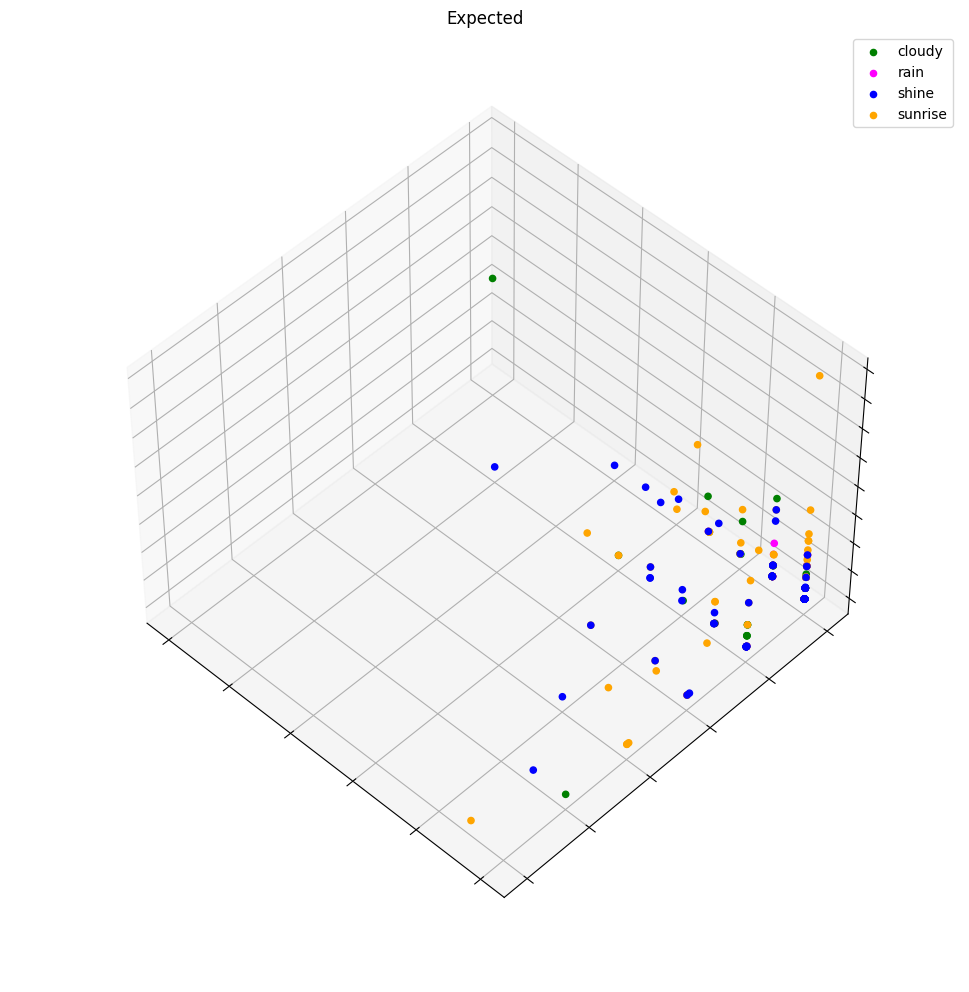

In [ ]:
fig = draw_3D(X, Y, 4, 2, 6, "Expected", labels=labels)
fig.set_size_inches(10, 10, forward=True)
fig.set_dpi(100)

plt.show()

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 8.ACP
</div>

In [75]:
# selection des colonnes à prendre en compte dans l'ACP
df_centre_reduit = pd.DataFrame(X.copy())
print("{:_} NAN".format(df_centre_reduit.isna().sum().sum()))
df_centre_reduit.shape

0 NAN


(400, 322)

In [76]:
from sklearn import decomposition
from sklearn import preprocessing

In [78]:
df_centre_reduit.shape

(400, 322)

In [79]:
# choix du nombre de composantes à calculer
ACP_NB_COMPOSANTES = df_centre_reduit.shape[1]

# préparation des données pour l'ACP
X_acp = df_centre_reduit.values
names = df_centre_reduit.index # ou data.index pour avoir les intitulés
features = df_centre_reduit.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X_acp)
X_scaled = std_scale.transform(X_acp)

# calculer les composantes principales
pca = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
x_projeected = pca.fit_transform(X_scaled)
pd.DataFrame(x_projeected, index=df_centre_reduit.index, columns=["F"+str(i+1) for i in range(ACP_NB_COMPOSANTES)])

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F313,F314,F315,F316,F317,F318,F319,F320,F321,F322
0,11.095613,1.883907,0.668536,-3.208675,0.221046,-2.751455,-1.396102,0.957597,0.786441,-3.521853,...,-0.000794,0.023559,-0.105623,-0.039065,0.031749,0.006094,-0.089697,0.001812,0.010339,1.455837e-17
1,2.752722,-3.197290,-1.592688,-0.787540,1.506630,0.407702,0.995819,-1.698296,-0.134015,0.728560,...,-0.062608,0.047208,0.021703,-0.169538,-0.121163,-0.108816,-0.003883,0.011030,0.066296,3.687017e-16
2,1.576105,-1.576556,-1.708764,0.842495,-3.242758,0.856730,-0.149578,0.515355,1.247402,-1.377839,...,0.237172,0.010688,-0.038907,-0.059479,-0.094147,-0.039263,-0.013363,0.115101,-0.031359,1.236216e-15
3,-1.704031,4.725975,4.107283,-2.637811,-1.966527,-1.500859,2.631078,-1.731537,-0.000279,0.707319,...,-0.048716,-0.112121,-0.089294,-0.095785,-0.010253,0.016230,-0.073391,-0.000829,0.009633,-1.792498e-16
4,4.868108,1.908091,-3.224163,-0.218681,-0.321695,-1.731885,-1.564136,0.174317,0.463392,-0.258125,...,-0.258491,0.028581,-0.047126,-0.130628,0.007036,-0.084799,0.145880,-0.018630,0.022375,1.056933e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-7.439335,-8.863962,4.032179,-1.543601,-3.751856,-1.199809,-2.496570,3.999834,-1.030599,0.395341,...,-0.173016,-0.088844,-0.088604,0.043725,0.022083,-0.064965,-0.198527,0.087398,0.024514,7.372824e-16
396,-0.176761,-5.589051,-0.388881,1.909547,2.050328,0.651223,-3.294309,-4.057051,-4.790270,-2.926047,...,0.014645,-0.002010,-0.037145,-0.078963,0.111148,-0.112605,0.134842,0.095393,-0.030133,-1.275098e-16
397,-6.119232,-5.706668,2.943140,0.917631,-0.831131,0.153574,0.117057,1.090698,-2.253929,1.912168,...,-0.070635,0.072381,0.024096,-0.014528,-0.105536,0.032325,-0.009129,-0.023518,0.000408,-4.314393e-16
398,3.261149,-4.144760,2.312534,3.612112,0.497938,-2.081865,0.977525,-0.475448,0.988643,4.762586,...,-0.018020,-0.059133,0.093027,-0.028828,0.102028,-0.003912,-0.026578,-0.033480,0.011526,6.671350e-16


In [80]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.figure(figsize=(18,7), facecolor='white')
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

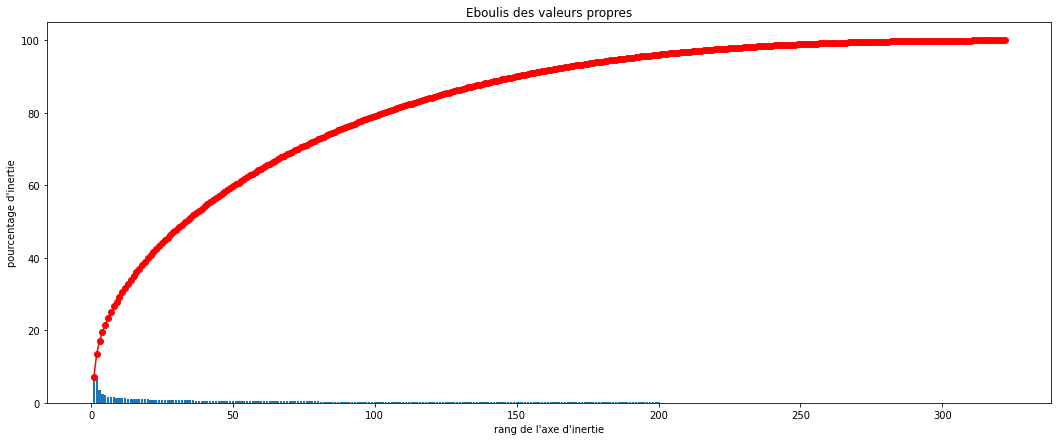

In [81]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

In [84]:
df_centre_reduit.head()

,0,1,2,3,4,5,6,7,8,9,...,312,313,314,315,316,317,318,319,320,321
0,0.000000,0.000000,0.0,0.013514,0.013514,0.040541,0.000000,0.027027,0.000000,0.000000,...,0.000000,0.013514,0.000000,0.000000,0.000000,0.0,0.013514,0.0,0.000000,0.013514
1,0.003333,0.000000,0.0,0.003333,0.013333,0.010000,0.000000,0.000000,0.006667,0.006667,...,0.006667,0.010000,0.003333,0.000000,0.003333,0.0,0.000000,0.0,0.010000,0.003333
2,0.000000,0.010000,0.0,0.003333,0.006667,0.000000,0.000000,0.006667,0.003333,0.003333,...,0.003333,0.003333,0.000000,0.016667,0.003333,0.0,0.003333,0.0,0.003333,0.006667
3,0.016667,0.003333,0.0,0.006667,0.000000,0.000000,0.006667,0.006667,0.006667,0.003333,...,0.000000,0.000000,0.010000,0.000000,0.013333,0.0,0.000000,0.0,0.000000,0.003333
4,0.003322,0.000000,0.0,0.006645,0.003322,0.003322,0.009967,0.006645,0.009967,0.000000,...,0.003322,0.006645,0.003322,0.000000,0.000000,0.0,0.000000,0.0,0.009967,0.009967


In [85]:
# choix du nombre de composantes à calculer
ACP_NB_COMPOSANTES = 150

axis_ranks = []

for i in range (0, ACP_NB_COMPOSANTES, 2):
    axis_ranks.append((i,i+1))
axis_ranks

[(0, 1),
 (2, 3),
 (4, 5),
 (6, 7),
 (8, 9),
 (10, 11),
 (12, 13),
 (14, 15),
 (16, 17),
 (18, 19),
 (20, 21),
 (22, 23),
 (24, 25),
 (26, 27),
 (28, 29),
 (30, 31),
 (32, 33),
 (34, 35),
 (36, 37),
 (38, 39),
 (40, 41),
 (42, 43),
 (44, 45),
 (46, 47),
 (48, 49),
 (50, 51),
 (52, 53),
 (54, 55),
 (56, 57),
 (58, 59),
 (60, 61),
 (62, 63),
 (64, 65),
 (66, 67),
 (68, 69),
 (70, 71),
 (72, 73),
 (74, 75),
 (76, 77),
 (78, 79),
 (80, 81),
 (82, 83),
 (84, 85),
 (86, 87),
 (88, 89),
 (90, 91),
 (92, 93),
 (94, 95),
 (96, 97),
 (98, 99),
 (100, 101),
 (102, 103),
 (104, 105),
 (106, 107),
 (108, 109),
 (110, 111),
 (112, 113),
 (114, 115),
 (116, 117),
 (118, 119),
 (120, 121),
 (122, 123),
 (124, 125),
 (126, 127),
 (128, 129),
 (130, 131),
 (132, 133),
 (134, 135),
 (136, 137),
 (138, 139),
 (140, 141),
 (142, 143),
 (144, 145),
 (146, 147),
 (148, 149)]

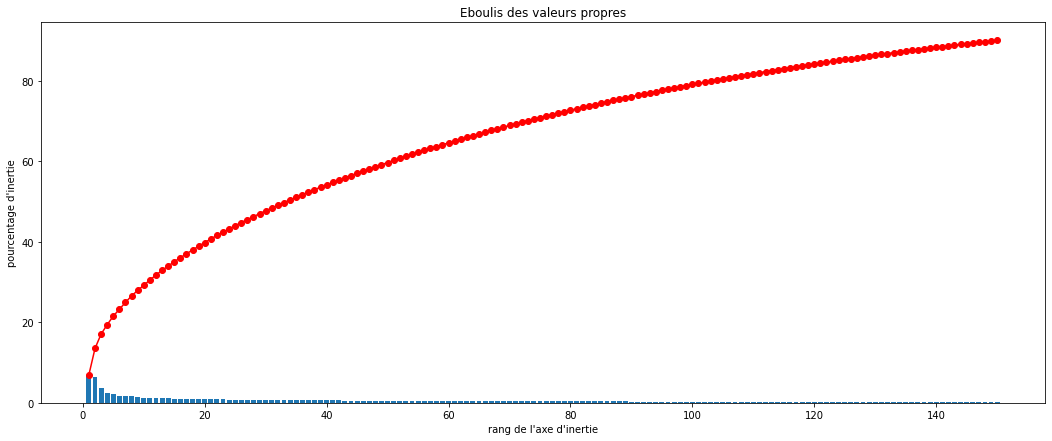

In [86]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

In [95]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=0.5, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            plt.figure(figsize=(10,10), facecolor="white")
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                valil = np.unique(illustrative_var)
                # On commence par traiter le NAN pour plus de lisibilité dans le graphe
                value = str(np.nan)
                if value in valil :
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, c=colors_dic(value, "blue"), s=100)
                    valil = valil[valil != value]
                for value in valil:
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, c=colors_dic.get(value, "blue"), s=100)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [88]:
from matplotlib.collections import LineCollection

In [100]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
                ax.set_facecolor("white")
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            fig.patch.set_facecolor("white")
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        

def display_factorial_planes_by_theme(X_projected,pca, n_comp, axis_ranks, alpha=0.5, illustrative_var=None, by_theme=False):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
            # affichage des points
            illustrative_var = np.array(illustrative_var)
            valil = np.unique(illustrative_var)

            figure, axes = plt.subplots(2,len(valil)//2)

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            
            # On commence par traiter le NAN pour plus de lisibilité dans le graphe
            value = str(np.nan)
            i = 0
            j = 0
            if value in valil :
                _display_one_scatter(X_projected, pca, axes[i][j], value, d1, d2, alpha,boundary, illustrative_var)
                valil = valil[valil != value]
                j += 1
            
            for value in valil:
                _display_one_scatter(X_projected, pca, axes[i][j], value, d1, d2, alpha,boundary, illustrative_var)
                
                j += 1
                if j >= (len(valil)//2):
                    i += 1
                    j = 0
            
            figure.set_size_inches(18.5, 7, forward=True)
            figure.set_dpi(100)
            figure.patch.set_facecolor("white")
            figure.suptitle("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def _display_one_scatter(X_projected, pca, axe,value, d1, d2, alpha, boundary, illustrative_var):
    selected = np.where(illustrative_var == value)
    c=colors_dic.get(value, "blue")
    axe.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, c=c, s=100)
    axe.legend()
    # nom des axes, avec le pourcentage d'inertie expliqué
    axe.set_xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
    axe.set_ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

    axe.set_xlim([-boundary,boundary])
    axe.set_ylim([-boundary,boundary])
    # affichage des lignes horizontales et verticales
    axe.plot([-100, 100], [0, 0], color='grey', ls='--')
    axe.plot([0, 0], [-100, 100], color='grey', ls='--')
    axe.set_facecolor("white")

In [ ]:
# Projection des individus
X_projected = pca.transform(X_scaled)
pcs = pca.components_

# Theme du ou des parcours auxquels appartient le cours (data, developpement, marketing, etc.)
theme = [df_origin.loc[index, "y"] for index in df_centre_reduit.index]

for rank in axis_ranks:
    # Projection des individus
    display_factorial_planes(X_projected, ACP_NB_COMPOSANTES, pca, [rank], illustrative_var = theme)
    # Cercle des corrélations
    display_circles(pcs, ACP_NB_COMPOSANTES, pca, [rank], labels = np.array(features))
    display_factorial_planes_by_theme(X_projected, pca, ACP_NB_COMPOSANTES, [rank], illustrative_var = theme, by_theme=True)

In [102]:
mlp_acp = MLPClassifier(verbose=verbose, max_iter=600000)
mlp_acp.fit(X_acp, Y)
mlp_acp.score(X_acp, Y)

1.0

In [104]:
# selection des colonnes à prendre en compte dans l'ACP
df_centre_reduit_test = pd.DataFrame(X_test.copy())
print("{:_} NAN".format(df_centre_reduit_test.isna().sum().sum()))
print(df_centre_reduit_test.shape)

# préparation des données pour l'ACP
X_acp_test = df_centre_reduit_test.values
names_test = df_centre_reduit_test.index # ou data.index pour avoir les intitulés
features_test = df_centre_reduit_test.columns

# Centrage et Réduction
std_scale_test = preprocessing.StandardScaler().fit(X_acp_test)
X_scaled_test = std_scale.transform(X_acp_test)

# calculer les composantes principales
round(mlp_acp.score(X_acp_test, Y_test),2)

0 NAN
(62, 322)


0.44

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 9.K-MEANS
</div>

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=random_state).fit(X)
y_pred = kmeans.predict(X)
centroids = kmeans.cluster_centers_
centroids

array([[0.0002381 , 0.00175549, 0.00784754, ..., 0.00130835, 0.01690776,
        0.00047619],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00070728, 0.00248636, 0.0011901 , ..., 0.00211438, 0.00492361,
        0.00021423],
       [0.        , 0.        , 0.        , ..., 0.00083333, 0.00082508,
        0.00082508]])

In [ ]:
y_pred

array([2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 3, 0, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 3, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,
       0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
Y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [ ]:
df_src["pred_kmean"] = y_pred
df_src

,picture,target,predict,cloudy_proba_0,rain_proba_1,shine_proba_2,sunrise_proba_3,pred_kmean
0,cloudy1.jpg,cloudy,cloudy,0.99,0.00,0.00,0.00,2
1,cloudy10.jpg,cloudy,cloudy,0.99,0.00,0.00,0.00,2
2,cloudy100.jpg,cloudy,cloudy,0.97,0.01,0.01,0.00,2
3,cloudy11.jpg,cloudy,cloudy,0.95,0.03,0.02,0.00,2
4,cloudy12.jpg,cloudy,cloudy,0.95,0.03,0.01,0.01,2
...,...,...,...,...,...,...,...,...
395,sunrise96.jpg,sunrise,sunrise,0.00,0.00,0.00,1.00,0
396,sunrise97.jpg,sunrise,sunrise,0.00,0.00,0.00,1.00,0
397,sunrise98.jpg,sunrise,sunrise,0.01,0.00,0.00,0.99,0
398,sunrise99.jpg,sunrise,sunrise,0.00,0.00,0.00,1.00,2


In [ ]:
round(kmeans.score(X, Y),2)

-7.1

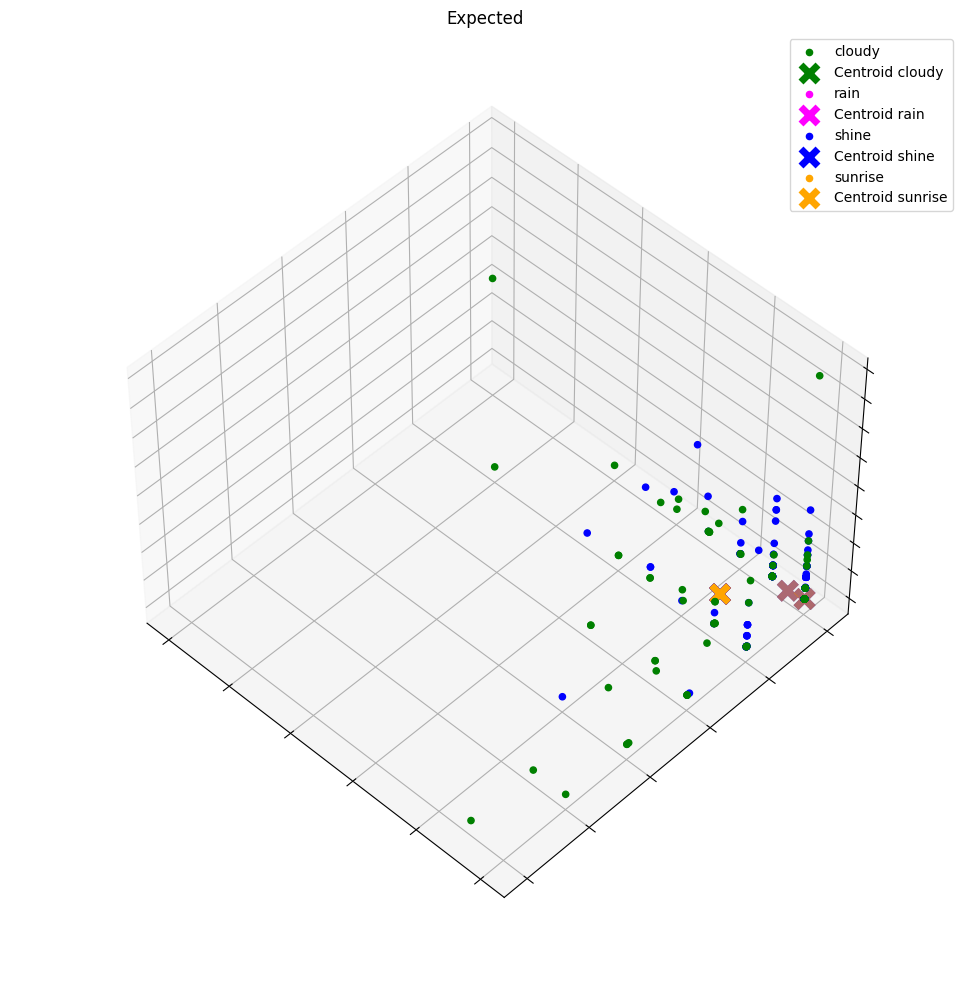

In [ ]:
fig = draw_3D(X, y_pred, 4, 2, 6, "Expected", labels=labels, centroids=centroids)
fig.set_size_inches(10, 10, forward=True)
fig.set_dpi(100)

plt.show()

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Annexes
</div>

In [ ]:
img_cloudy_path = file_path + "cloudy10.jpg"

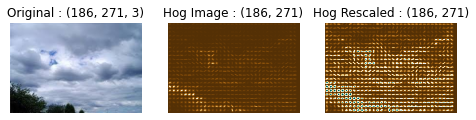

In [ ]:
img_cloudy, resized_img_cloudy, hog_image_cloudy = ara_pict.show_hog(img_path=img_cloudy_path)